<모델 개요>
- “Yeast Dataset”은 효모 유전자의 microarray expression data와 phylogenetic profiles를 포함한 multi-label classification용 데이터셋.
- 각 인스턴스(유전자)가 수행하는 여러 생물학적 기능을 예측하는 것이 모델의 목표.

<Dataset 특징>
1. Instance: 하나의 유전자(gene)을 나타냄.
2. Features: microarray expression data와 phylogenetic profiles로 총 103개가 구성됨.
- microarray expression data: 유전자 발현 수준을 나타내는 numerical 데이터
- phylogenetic profiles: 여러 생물종에서 해당 유전자의 존재 유무를 나타내는 symbolic 데이터
3. Labels: 하나의 유전자에 대해 14개의 label(multi-label)로 할당됨.
- 각 label은 생물학적 기능을 의미하며, binary value(0 또는 1)를 가짐.
- 하나의 gene은 여러 개의 기능을 가질 수 있음. Ex.[1, 0, 0, 1, … ,0]
- physiological process, molecular function, cellular component 등으로 14개의 label이 구성됨.

이를 통해 gene function prediction과 생물학적 데이터 분석에서 주로 활용됨.

***유전자가 갖는 여러 생물학적 기능을 예측하는 모델의 개발 절차***

**1. 데이터 분석 및 탐색(EDA)**

•	데이터의 분포, 상관관계 등을 살펴보며 각 feature가 target에 어떤 영향을 미치는지 파악함.

•	OpenML에서 data를 로드해오기 위해 fetch_openml로 Yeast Dataset을 가져와 데이터 구조를 확인함.

In [1]:
# 주어진 dataset의 결측치 여부, 데이터 타입, 기초 통계 요약 확인
# 사이킷런 0.22 버전 이전의 경우 fetch_mldata

from sklearn.datasets import fetch_openml
yeast = fetch_openml('yeast', version=4, as_frame=True)
# as_frame=True -> pandas DataFrame 형태로 로드

X = yeast['data']
Y = yeast['target']

# 데이터 구조 확인하기
print("Feature Shape:", X.shape)
print("Label Shape:", Y.shape)
print(X.head())
print(Y.head())
print(X.info())
print(Y.info())
print(X.describe())
print(Y.describe())

Feature Shape: (2417, 103)
Label Shape: (2417, 14)
       Att1      Att2      Att3      Att4      Att5      Att6      Att7  \
0  0.004168 -0.170975 -0.156748 -0.142151  0.058781  0.026851  0.197719   
1 -0.103956  0.011879 -0.098986 -0.054501 -0.007970  0.049113 -0.030580   
2  0.509949  0.401709  0.293799  0.087714  0.011686 -0.006411 -0.006255   
3  0.119092  0.004412 -0.002262  0.072254  0.044512 -0.051467  0.074686   
4  0.042037  0.007054 -0.069483  0.081015 -0.048207  0.089446 -0.004947   

       Att8      Att9     Att10  ...     Att94     Att95     Att96     Att97  \
0  0.041850  0.066938 -0.056617  ...  0.006166 -0.012976 -0.014259 -0.015024   
1 -0.077933 -0.080529 -0.016267  ...  0.007680  0.027719 -0.085811  0.111123   
2  0.013646 -0.040666 -0.024447  ...  0.096277 -0.044932 -0.089470 -0.009162   
3 -0.007670  0.079438  0.062184  ... -0.083809  0.200354 -0.075716  0.196605   
4  0.064456 -0.133387  0.068878  ... -0.060467  0.044351 -0.057209  0.028047   

      Att98     A

**2. 데이터 전처리 및 Train/Test Split**

1. Feature Scaling

- Numerical 데이터: 정규화(Standardization) 필요.

- Symbolic 데이터: One-Hot Encoding 또는 Label Encoding으로 처리.

2. Train/Test Split: 일정 비율로 랜덤하게 분할함.

1. One-Hot Encoding

- 고유한 symbolic 값을 새로운 이진 벡터로 변환.

- 값이 범주에 해당하면 1, 그렇지 않으면 0.


---

장점: 범주 순서가 없는 데이터에 적합

단점: feature 수가 많으면 급격히 차원 증가(차원의 저주)



2. Label Encoding

- 고유한 symbolic 값을 정수로 변환.

-  ex. ["A", "B", "C"] -> [0,1,2]


---

장점: feature 수가 많아도 차원을 증가시키지 않아 급격한 데이터 크기 증가X.

단점: 범주 순서 존재할 시 적절하지 않음. (순서, 크기 관계를 잘못 학습할 가능성 존재)

In [3]:
# dataframe 형태의 label(FALSE/TRUE)를 이진벡터(0/1)로 변환
Y_binary = Y.applymap(lambda x: 1 if x == "TRUE" else 0).values
import numpy as np
Y_binary = np.array(Y_binary, dtype=int)

<ipython-input-3-ee8769c9314c>:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  Y_binary = Y.applymap(lambda x: 1 if x == "TRUE" else 0).values


그러나 우리는 openml로 data를 로드했기 때문에 Y는 dataframe 형태로 저장된 상태임. 따라서 Y.applymap()을 이용해서 T/F를 이진벡터 0/1로 변환함.

1. Y.applymap():

DataFrame의 각 원소에 함수(lambda)를 적용하는 함수.

"TRUE"는 1, "FALSE"는 0으로 변환.

2. .values:

변환된 DataFrame을 NumPy 배열로 추출.(모델학습을 위하여)

In [4]:
print(Y_binary)

[[0 0 0 ... 1 1 0]
 [0 0 1 ... 0 0 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 0 0 ... 1 1 0]
 [0 0 0 ... 1 1 0]
 [0 1 1 ... 1 1 0]]


numpy 배열 형식으로 변환된 Y_binary

In [5]:
# Numerical 데이터 정규화
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [6]:
# Train/Test Split as 0.8:0.2
# with random seed=42
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y_binary,
                                                    test_size=0.2, random_state=42)

print("Training Data Shape:", X_train.shape, y_train.shape)
print("Test Data Shape:", X_test.shape, y_test.shape)

Training Data Shape: (1933, 103) (1933, 14)
Test Data Shape: (484, 103) (484, 14)


In [7]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("Unique values in y_train:", np.unique(y_train))

X_train shape: (1933, 103)
y_train shape: (1933, 14)
Unique values in y_train: [0 1]


Feature가 14개로 늘어난 이유

: OneHotEncoder로 symbolic 데이터를 이진 벡터로 변환하고 각각 새로운 열로 확장하기 때문에 입력 데이터의 차원(= feature 개수)이 증가함.

# 각 라벨의 빈도수를 막대그래프 시각화로 파악

=> 클래스 불균형 감지 가능

[[0 1 1 ... 1 1 0]
 [1 1 0 ... 1 1 0]
 [0 1 1 ... 0 0 0]
 ...
 [1 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 0 1 ... 1 1 0]]


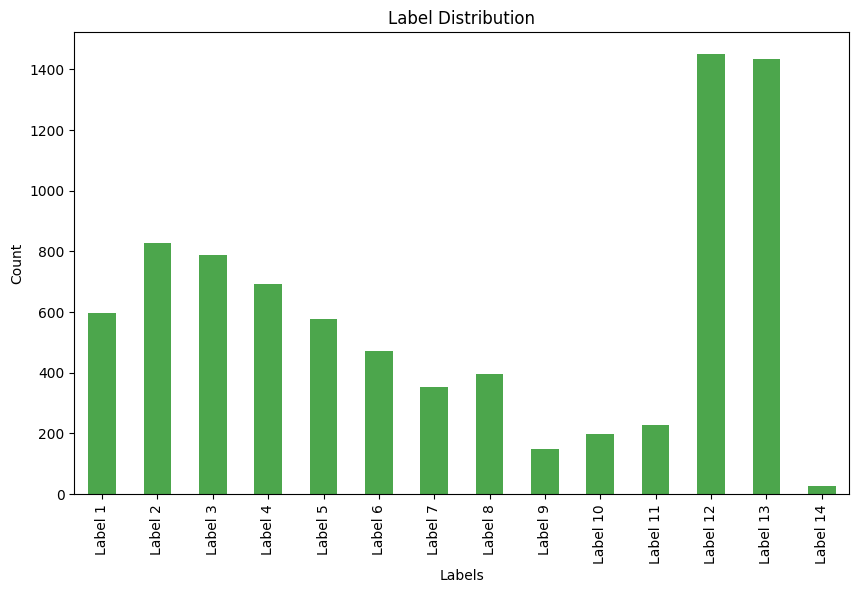

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Y 데이터의 라벨별 분포 시각화
# y_train 데이터(다중 라벨 데이터)를 DataFrame로 변환, column name Label 1, Label 2, ... 설정
label_counts = pd.DataFrame(y_train,
                            columns=[f"Label {i+1}" for i in range(y_train.shape[1])]).sum()
                            #  값이 1(TRUE)인 데이터(positive samples)를 합산
print(y_train) # df type으로 변환된 y_train

plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar', color='green', alpha=0.7) # Bar graph 생성
plt.title('Label Distribution')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

Label 12와 Label 13의 경우 다른 라벨들에 비해 압도적으로 많은 빈도,

반면 Label 14는 거의 데이터가 없는 상황.

=> 빈도가 높은 라벨에 편향될 가능성이 크며, 빈도낮은 라벨 학습이 제대로 이루어지지 않을 확률이 존재함.

# 불균형 데이터를 다루는 방법

1. 데이터 증강

Oversampling (과샘플링)

: 빈도 낮은 라벨의 데이터를 증강.

* SMOTE (Synthetic Minority Oversampling Technique) : 기존 데이터 특성 보존, 소수 클래스의 샘플 생성.

* Random Oversampling : 소수 클래스 데이터를 단순 복제 -> 데이터 양 증가.

Undersampling (소샘플링)

: 빈도 높은 라벨의 데이터 일부 제거. (데이터 손실 유의 필요)

---

2. 가중치 조정

- 클래스 가중치를 부여 -> 빈도 낮은 라벨일수록 더 큰 가중치 부여.
"class_weight='balanced'" -> 불균형 자동 보정

- Logistic Regression, SVM, Random Forest 등의 모델에서 지원

---


3. 라벨 분포 조정

- 각 데이터 샘플의 라벨 수 조정.
- 너무 많은 라벨을 가진 샘플 제거
- 새로운 데이터 샘플 생성

---


4. 알고리즘 선택

불균형 데이터에 특화된 모델 or 학습 전략 사용

XGBoost, CatBoost, LightGBM => 불균형 데이터에서도 좋은 성능

## 모델 개발
1. Baseline 모델:

- Random Forest 또는 Logistic Regression을 기반으로 하는 모델.

2. Multi-label Classification:

- Scikit-learn OneVsRestClassifier 또는 MultiOutputClassifier 사용.

# Baseline 모델
: 프로젝트에서 가장 기본적인 기준 성능이 되는 모델

복잡한 알고리즘 도입 전 단순한 방법으로 성능 측정
-> 향후 모델 개선 효과를 평가하는 기준점이 됨.


---

Random Forest: 앙상블 학습 기법(여러 개의 decision tree를 병렬 학습)

분류, 회귀, 다중 클래스/라벨 모두 효과적

over-fitting 발생가능성이 낮음 (트리 개별 성능에 의존X, 평균화)

---

Logistic Regression: 선형 모델. 이진 분류 문제 해결을 위해 설계됨.

확률 기반으로 클래스 예측을 수행.

모델이 단순해 데이터 분석 or 기본적인 성능 기준을 세우기 적합.

다중 라벨 문제에는 확장 기법(OneVsRestClassifier)과 함께 사용하며 라벨별 '선형 결정 경계'를 학습함.

reqularization을 통해 과적합 방지 -> penalty 매개변수와 L1, L2 규제

# Multi-Label Classification
: 하나의 샘플에 여러 개의 라벨이 할당될 수 있는 classfication

다중 라벨: 한 샘플에 여러 클래스 할당 가능 <=> 다중 클래스: 한 샘플에 하나의 클래스만 할당함.

---

OneVsRestClassifier(OvR)

- 각 라벨이 **독립적인 이진 분류기로 학습**됨.

- 다중 클래스/라벨을 여러 개의 이진 분류 문제로 전환

- **반드신 이진 분류 모델을 기반**으로 학습함.

- 단점: **라벨 간 상관관계 고려가 불가함**.

- 벙렬 처리 기본지원 X.

- **다중 클래스/라벨** 문제 해결 목적

---

MultiOutputClassifier

- 각 라벨이 **독립적으로 학습**됨.

- 다중 라벨을 **개별 분류기로 전환, 병렬적으로 학습**함.

- **이진 분류/다중클래스 모델 모두** 사용 가능함.

- 벙렬 처리 가능함 -> 라벨이 많은 경우 유리하게 적용.

- 단점: **라벨 간 상관관계 고려가 불가함**.

- **다중 라벨** 문제 해결 목적

## 고급 모델 및 튜닝
1. 하이퍼파라미터 최적화:

- GridSearchCV 혹은 RandomizedSearchCV 사용.

**(1) 하이퍼파라미터 튜닝**

Grid Search: 가능한 모든 조합 탐색 -> 속도 느림.

Randomized Search: 랜덤 샘플링 -> 빠른 탐색 가능.

Bayesian Optimization: Optuna, Hyperopt 사용(효율과 성능 좋음)

**(2) 성능 지표 분석**

Precision, Recall, F1-Score: 각 라벨별/전체 성능 확인 가능.

ROC Curve 및 AUC Score: 각 클래스에 대한 구분 능력 평가.

- ROC: 라벨별 이진 분류 성능의 평가 지표


In [39]:
# OneVsRest로 R.F를 확장한 모델

from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import hamming_loss, accuracy_score

# 모델 정의하기
# BaseLine model로 Random forest를 선택.
# OneVsRest로 R.F를 확장하여 멀티 라벨 분류를 다룸.
model = OneVsRestClassifier(RandomForestClassifier(random_state=42))

# 학습 데이터셋으로 fitting
# OneVsRest -> 각 레벨에 대해 독립적으로 RF 학습 진행.
model.fit(X_train, y_train)

# fit한 model과 test data로 예측값 구하기
# 마찬가지로 label별 독립적인 결과 생성
y_pred = model.predict(X_test)

# 성능평가
print("Hamming Loss:", hamming_loss(y_test, y_pred))
# Hamming Loss: 샘플 내 라벨별 오답 비율
print("Accuracy:", accuracy_score(y_test, y_pred))
# Accuracy: 샘플별 예측 성공 비율

Hamming Loss: 0.18668831168831168
Accuracy: 0.1797520661157025


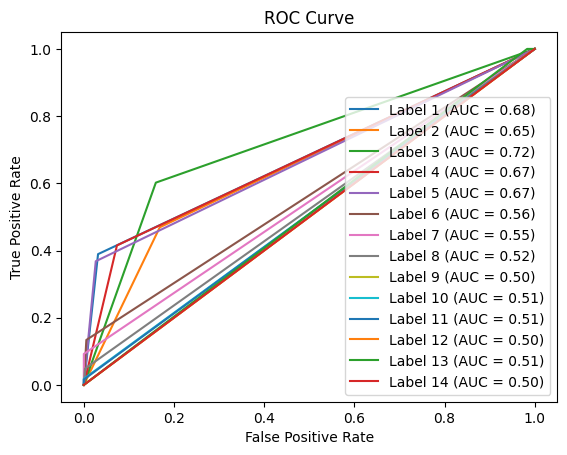

In [40]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

for i in range(y_test.shape[1]):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred[:, i])
    plt.plot(fpr, tpr, label=f'Label {i+1} (AUC = {auc(fpr, tpr):.2f})')

plt.xlabel('False Positive Rate') # False를 True로 잘못 판단
plt.ylabel('True Positive Rate') # True를 False로 잘못 판단
plt.title('ROC Curve')
plt.legend()
plt.show()

클래스 불균형 완화 - 클래스 가중치를 사용하는 Random Forest

In [41]:
# OneVsRest로 R.F를 확장한 모델

from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import hamming_loss, accuracy_score

# 모델 정의하기
# BaseLine model로 Random forest를 선택.
# OneVsRest로 R.F를 확장하여 멀티 라벨 분류를 다룸.
model = OneVsRestClassifier(RandomForestClassifier(class_weight="balanced", random_state=42))

# 학습 데이터셋으로 fitting
# OneVsRest -> 각 레벨에 대해 독립적으로 RF 학습 진행.
model.fit(X_train, y_train)

# fit한 model과 test data로 예측값 구하기
# 마찬가지로 label별 독립적인 결과 생성
y_pred = model.predict(X_test)

# 성능평가
print("Hamming Loss:", hamming_loss(y_test, y_pred))
# Hamming Loss: 샘플 내 라벨별 오답 비율
print("Accuracy:", accuracy_score(y_test, y_pred))
# Accuracy: 샘플별 예측 성공 비율

Hamming Loss: 0.18963990554899646
Accuracy: 0.1590909090909091


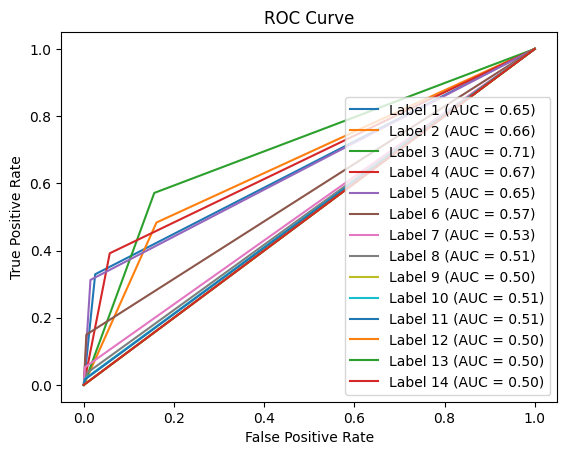

In [42]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

for i in range(y_test.shape[1]):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred[:, i])
    plt.plot(fpr, tpr, label=f'Label {i+1} (AUC = {auc(fpr, tpr):.2f})')

plt.xlabel('False Positive Rate') # False를 True로 잘못 판단
plt.ylabel('True Positive Rate') # True를 False로 잘못 판단
plt.title('ROC Curve')
plt.legend()
plt.show()

In [43]:
# OneVsRest로 logistic Regression을 확장한 모델

from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import hamming_loss, accuracy_score

# 모델 정의하기
# Logistic Regression 모델 정의 = BaseLine
log_reg = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42)
# max_iter=최대 학습반복 횟수, random_state=재현을 위한 난수 설정
# OneVsRest로 logistic을 확장하여 멀티 라벨 분류를 다룸.
model = OneVsRestClassifier(log_reg)

# 학습 데이터셋으로 fitting
# OneVsRest -> 각 레벨에 대해 독립적으로 RF 학습 진행.
model.fit(X_train, y_train)

# fit한 model과 test data로 예측값 구하기
# 마찬가지로 label별 독립적인 결과 생성
y_pred = model.predict(X_test)

# 성능평가
print("Hamming Loss:", hamming_loss(y_test, y_pred))
# Hamming Loss: 샘플 내 라벨별 오답 비율
print("Accuracy:", accuracy_score(y_test, y_pred))
# Accuracy: 샘플별 예측 성공 비율

Hamming Loss: 0.20454545454545456
Accuracy: 0.15702479338842976


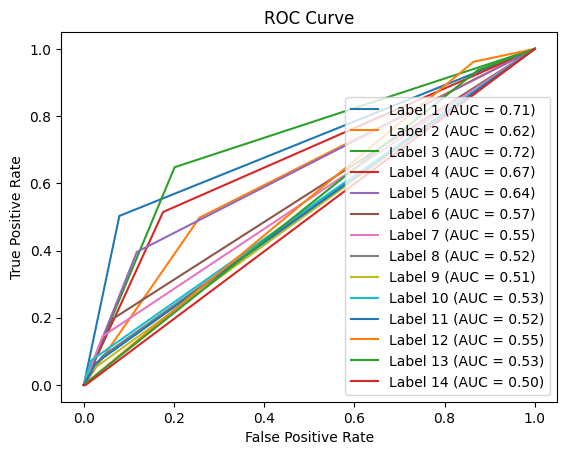

In [44]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

for i in range(y_test.shape[1]):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred[:, i])
    plt.plot(fpr, tpr, label=f'Label {i+1} (AUC = {auc(fpr, tpr):.2f})')

plt.xlabel('False Positive Rate') # False를 True로 잘못 판단
plt.ylabel('True Positive Rate') # True를 False로 잘못 판단
plt.title('ROC Curve')
plt.legend()
plt.show()

클래스 불균형 완화 - 클래스 가중치를 사용하는 Logistic Regression

In [47]:
# OneVsRest로 logistic Regression을 확장한 모델 - balanced 가중치 사용

from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import hamming_loss, accuracy_score

# 모델 정의하기
# Logistic Regression 모델 정의 = BaseLine
log_reg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
# max_iter=최대 학습반복 횟수, random_state=재현을 위한 난수 설정
# OneVsRest로 logistic을 확장하여 멀티 라벨 분류를 다룸.
model = OneVsRestClassifier(log_reg)

# 학습 데이터셋으로 fitting
# OneVsRest -> 각 레벨에 대해 독립적으로 RF 학습 진행.
model.fit(X_train, y_train)

# fit한 model과 test data로 예측값 구하기
# 마찬가지로 label별 독립적인 결과 생성
y_pred = model.predict(X_test)

# 성능평가
print("Hamming Loss:", hamming_loss(y_test, y_pred))
# Hamming Loss: 샘플 내 라벨별 오답 비율
print("Accuracy:", accuracy_score(y_test, y_pred))
# Accuracy: 샘플별 예측 성공 비율

Hamming Loss: 0.32718417945690675
Accuracy: 0.0640495867768595


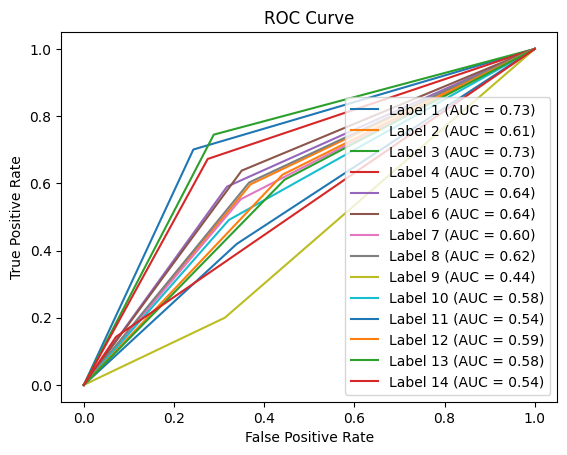

In [48]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

for i in range(y_test.shape[1]):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred[:, i])
    plt.plot(fpr, tpr, label=f'Label {i+1} (AUC = {auc(fpr, tpr):.2f})')

plt.xlabel('False Positive Rate') # False를 True로 잘못 판단
plt.ylabel('True Positive Rate') # True를 False로 잘못 판단
plt.title('ROC Curve')
plt.legend()
plt.show()

In [45]:
# MultiOutputClassifier로 Random Forest를 확장한 모델

from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import hamming_loss, accuracy_score, classification_report

# MultiOutputClassifier로 R.F 확장
# BaseLine model로 Random forest를 선택.
multi_output_model = MultiOutputClassifier(RandomForestClassifier(class_weight="balanced", random_state=42))

# trainset fitting
# 각 라벨에 대해 독립적으로 이진 분류기 학습
multi_output_model.fit(X_train, y_train)

# testset predict
y_pred = multi_output_model.predict(X_test)

# 성능 평가
print("Hamming Loss:", hamming_loss(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

# 라벨별 세부 성능
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
# 라벨별 정밀도(precision), recall(재현율), F1-score 출력

Hamming Loss: 0.18963990554899646
Accuracy Score: 0.1590909090909091

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.33      0.48       167
           1       0.70      0.48      0.57       211
           2       0.71      0.57      0.63       196
           3       0.79      0.39      0.52       171
           4       0.90      0.31      0.46       144
           5       0.90      0.15      0.26       127
           6       0.80      0.05      0.10        76
           7       0.50      0.04      0.07        83
           8       0.00      0.00      0.00        30
           9       0.50      0.02      0.04        55
          10       0.50      0.02      0.03        62
          11       0.76      1.00      0.86       366
          12       0.75      1.00      0.86       365
          13       0.00      0.00      0.00         7

   micro avg       0.76      0.55      0.64      2060
   macro avg       0.62      0.31      0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


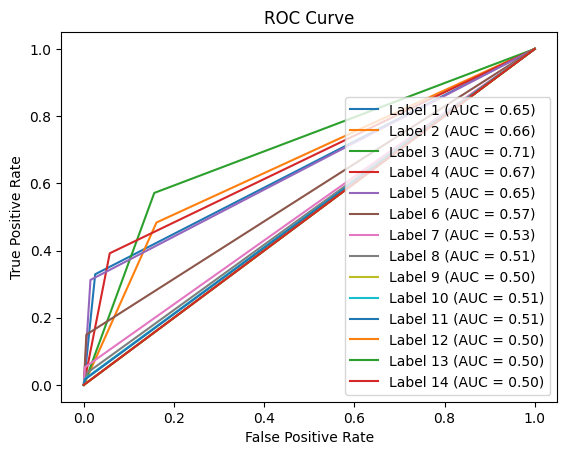

In [46]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

for i in range(y_test.shape[1]):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred[:, i])
    plt.plot(fpr, tpr, label=f'Label {i+1} (AUC = {auc(fpr, tpr):.2f})')

plt.xlabel('False Positive Rate') # False를 True로 잘못 판단
plt.ylabel('True Positive Rate') # True를 False로 잘못 판단
plt.title('ROC Curve')
plt.legend()
plt.show()

In [49]:
# MultiOutputClassifier로 Logistic Regression를 확장한 모델

from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import hamming_loss, accuracy_score, classification_report

# Logistic Regression 모델 정의 = BaseLine
log_reg = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42)
# max_iter=최대 학습반복 횟수, random_state=재현을 위한 난수 설정

# MultiOutputClassifier로 L.R 확장
multi_output_model = MultiOutputClassifier(log_reg)

# trainset fitting
# 각 라벨에 대해 독립적으로 이진 분류기 학습
multi_output_model.fit(X_train, y_train)

# testset predict
y_pred = multi_output_model.predict(X_test)

# 성능 평가
print("Hamming Loss:", hamming_loss(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

# 라벨별 세부 성능
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
# 라벨별 정밀도(precision), recall(재현율), F1-score 출력

Hamming Loss: 0.20454545454545456
Accuracy Score: 0.15702479338842976

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.50      0.61       167
           1       0.60      0.50      0.54       211
           2       0.69      0.65      0.67       196
           3       0.62      0.51      0.56       171
           4       0.59      0.40      0.47       144
           5       0.52      0.20      0.29       127
           6       0.39      0.14      0.21        76
           7       0.30      0.08      0.13        83
           8       0.25      0.03      0.06        30
           9       0.36      0.07      0.12        55
          10       0.27      0.06      0.10        62
          11       0.78      0.96      0.86       366
          12       0.77      0.94      0.84       365
          13       0.00      0.00      0.00         7

   micro avg       0.69      0.59      0.64      2060
   macro avg       0.49      0.36      0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


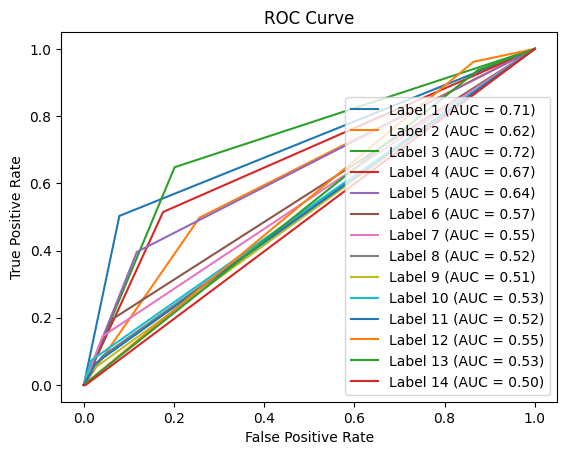

In [50]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

for i in range(y_test.shape[1]):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred[:, i])
    plt.plot(fpr, tpr, label=f'Label {i+1} (AUC = {auc(fpr, tpr):.2f})')

plt.xlabel('False Positive Rate') # False를 True로 잘못 판단
plt.ylabel('True Positive Rate') # True를 False로 잘못 판단
plt.title('ROC Curve')
plt.legend()
plt.show()

클래스 불균형 완화 - 클래스 가중치를 사용하는 Logistic Regression

In [51]:
# MultiOutputClassifier로 Logistic Regression를 확장한 모델

from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import hamming_loss, accuracy_score, classification_report

# Logistic Regression 모델 정의 = BaseLine
log_reg = LogisticRegression(class_weight='balanced', solver='lbfgs', max_iter=1000, random_state=42)
# max_iter=최대 학습반복 횟수, random_state=재현을 위한 난수 설정

# MultiOutputClassifier로 L.R 확장
multi_output_model = MultiOutputClassifier(log_reg)

# trainset fitting
# 각 라벨에 대해 독립적으로 이진 분류기 학습
multi_output_model.fit(X_train, y_train)

# testset predict
y_pred = multi_output_model.predict(X_test)

# 성능 평가
print("Hamming Loss:", hamming_loss(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

# 라벨별 세부 성능
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
# 라벨별 정밀도(precision), recall(재현율), F1-score 출력

Hamming Loss: 0.32718417945690675
Accuracy Score: 0.0640495867768595

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.70      0.65       167
           1       0.56      0.60      0.58       211
           2       0.64      0.74      0.69       196
           3       0.57      0.67      0.62       171
           4       0.44      0.59      0.50       144
           5       0.39      0.64      0.49       127
           6       0.23      0.55      0.32        76
           7       0.25      0.60      0.36        83
           8       0.04      0.20      0.07        30
           9       0.16      0.49      0.25        55
          10       0.15      0.42      0.23        62
          11       0.81      0.63      0.71       366
          12       0.81      0.61      0.70       365
          13       0.03      0.14      0.05         7

   micro avg       0.47      0.62      0.53      2060
   macro avg       0.41      0.54      0.

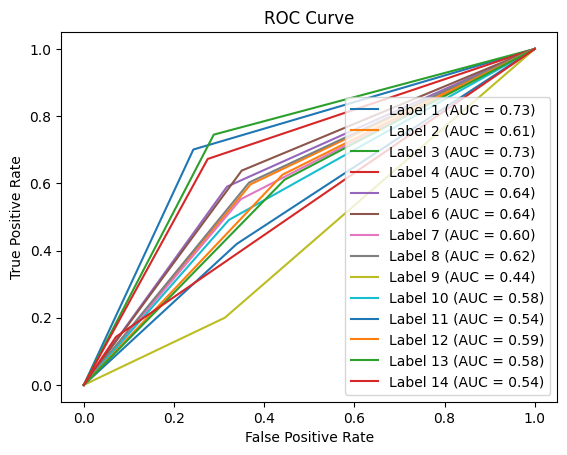

In [52]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

for i in range(y_test.shape[1]):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred[:, i])
    plt.plot(fpr, tpr, label=f'Label {i+1} (AUC = {auc(fpr, tpr):.2f})')

plt.xlabel('False Positive Rate') # False를 True로 잘못 판단
plt.ylabel('True Positive Rate') # True를 False로 잘못 판단
plt.title('ROC Curve')
plt.legend()
plt.show()

2. Gradient Boosting 모델:

- XGBoost, LightGBM 알고리즘 추가.

- 트리 기반 모델(스케일링 불필요)의 확장으로 학습 속도와 정확도가 뛰어남.

In [55]:
from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier

model = OneVsRestClassifier(XGBClassifier(scale_pos_weight=3,
                                          use_label_encoder=False, eval_metric="logloss"))
model.fit(X_train, y_train)


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:29:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:29:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:29:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:29:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:29:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

OneVsRestClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='logloss',
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...))

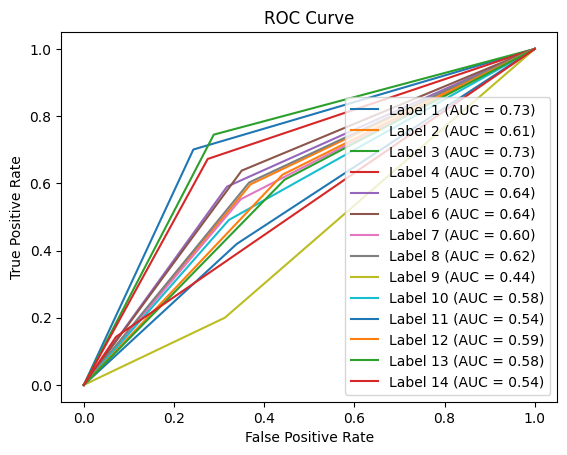

In [56]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

for i in range(y_test.shape[1]):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred[:, i])
    plt.plot(fpr, tpr, label=f'Label {i+1} (AUC = {auc(fpr, tpr):.2f})')

plt.xlabel('False Positive Rate') # False를 True로 잘못 판단
plt.ylabel('True Positive Rate') # True를 False로 잘못 판단
plt.title('ROC Curve')
plt.legend()
plt.show()